# Diet Classification

# Import Packages

In [244]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')

## Import dataset

In [245]:
diet_data = pd.read_csv('../data/All_Diets.csv')
print(diet_data.shape)
diet_data.head()

(7806, 8)


,Diet_type,Recipe_name,Cuisine_type,Protein(g),Carbs(g),Fat(g),Extraction_day,Extraction_time
0,paleo,Bone Broth From 'Nom Nom Paleo',american,5.22,1.29,3.20,2022-10-16,17:20:09
1,paleo,"Paleo Effect Asian-Glazed Pork Sides, A Sweet ...",south east asian,181.55,28.62,146.14,2022-10-16,17:20:09
2,paleo,Paleo Pumpkin Pie,american,30.91,302.59,96.76,2022-10-16,17:20:09
3,paleo,Strawberry Guacamole recipes,mexican,9.62,75.78,59.89,2022-10-16,17:20:09
4,paleo,"Asian Cauliflower Fried ""Rice"" From 'Nom Nom P...",chinese,39.84,54.08,71.55,2022-10-16,17:20:09


## Dataset Exploration (MS2)

Total Number of Observations: 7806

Number of Attributes: 6

| Attribute | Explanation |
|-----------|-------------|
|**Diet_type** | The type of diet the recipe fits into. |
| **Recipe_name**| The name of the recipe.|
| **Cuisine_type**| The type of cuisine the recipe belongs to. |
| **Protein(g)**| The amount of protein in the recipe, measured in grams. |
| **Carbs(g)**| The amount of carbohydrates in the recipe, measured in grams. |
| **Fat(g)**| The amount of fat in the recipe, measured in grams. |
| **Extraction_day**| The day the data was extracted. |
| **Extraction_time**| The time the data was extracted. |

In [246]:
diet_data.describe().round(2)

,Protein(g),Carbs(g),Fat(g)
count,7806.00,7806.00,7806.00
mean,83.23,152.12,117.33
std,89.80,185.91,122.10
min,0.00,0.06,0.00
25%,24.42,36.16,41.07
50%,56.28,93.42,84.86
75%,112.36,205.92,158.29
max,1273.61,3405.55,1930.24


In [247]:
diet_types = diet_data['Diet_type'].unique()
print(diet_types)

['paleo' 'vegan' 'keto' 'mediterranean' 'dash']


In [248]:
cuisine_types = diet_data['Cuisine_type'].unique()
print(cuisine_types)

['american' 'south east asian' 'mexican' 'chinese' 'mediterranean'
 'italian' 'french' 'indian' 'nordic' 'eastern europe' 'central europe'
 'kosher' 'british' 'caribbean' 'south american' 'middle eastern' 'asian'
 'japanese' 'world']


In [249]:
null_counts = diet_data.isnull().sum()
print(null_counts)

Diet_type          0
Recipe_name        0
Cuisine_type       0
Protein(g)         0
Carbs(g)           0
Fat(g)             0
Extraction_day     0
Extraction_time    0
dtype: int64


In [250]:
diet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7806 entries, 0 to 7805
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Diet_type        7806 non-null   object 
 1   Recipe_name      7806 non-null   object 
 2   Cuisine_type     7806 non-null   object 
 3   Protein(g)       7806 non-null   float64
 4   Carbs(g)         7806 non-null   float64
 5   Fat(g)           7806 non-null   float64
 6   Extraction_day   7806 non-null   object 
 7   Extraction_time  7806 non-null   object 
dtypes: float64(3), object(5)
memory usage: 488.0+ KB


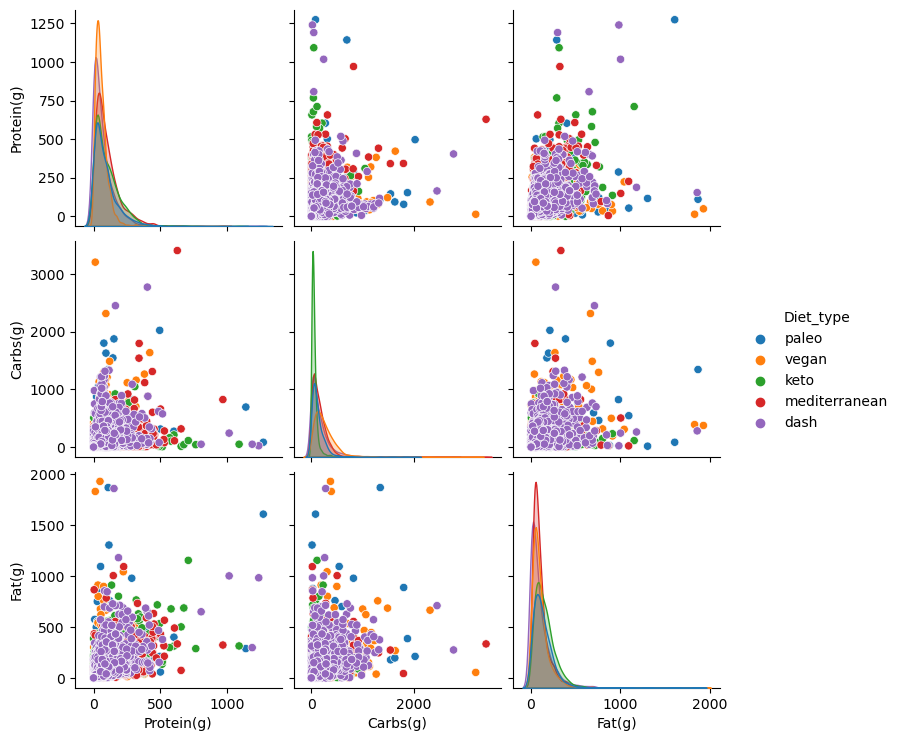

In [251]:
sns.pairplot(diet_data, hue='Diet_type', diag_kind='kde')

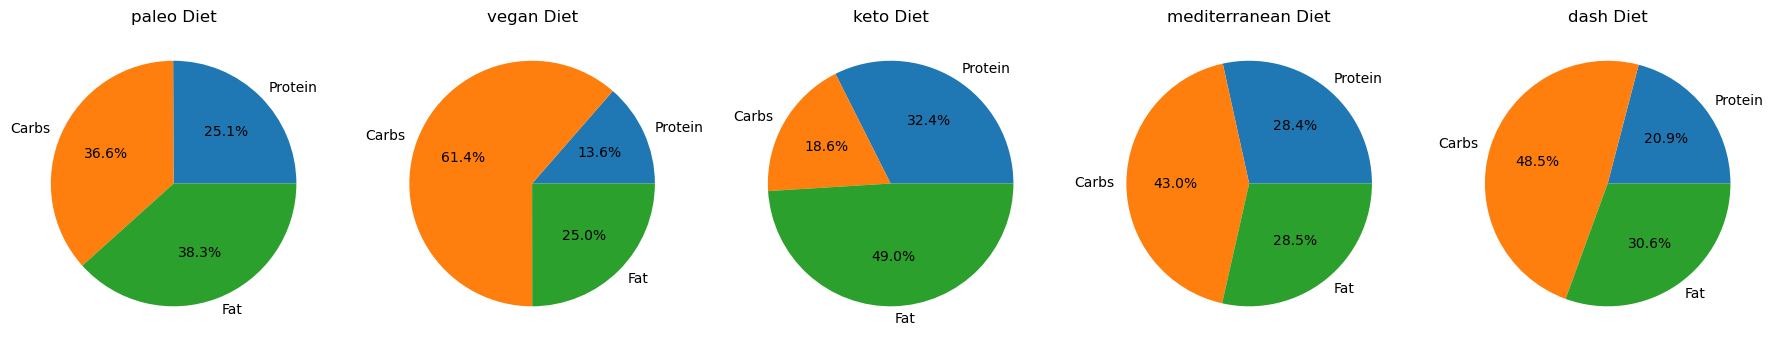

In [252]:
fig, axes = plt.subplots(1, 5, figsize=(18, 6)) 
for i, diet_type in enumerate(diet_data['Diet_type'].unique()): 
    df_grouped = diet_data[diet_data['Diet_type'] == diet_type]
    axes[i].pie(df_grouped[['Protein(g)','Carbs(g)','Fat(g)']].sum(), labels=['Protein', 'Carbs', 'Fat'], autopct='%1.1f%%') 
    axes[i].set_title(f'{diet_type} Diet') 
# Adjust layout and display 
plt.tight_layout()
plt.show()

# Pre-Processing (MS3)

### Clean Up

In [253]:
diet_data = diet_data.rename(
    columns={
        'Diet_type': 'Diet', 
        'Recipe_name': 'Recipe',
        'Cuisine_type': 'Cuisine',
        'Protein(g)': 'Protein',
        'Carbs(g)': 'Carbs',
        'Fat(g)': 'Fat',
        })
print(diet_data.columns)

Index(['Diet', 'Recipe', 'Cuisine', 'Protein', 'Carbs', 'Fat',
       'Extraction_day', 'Extraction_time'],
      dtype='object')


### Drop `Extraction Date` and `Extraction Time`

In [254]:
dd_processed = diet_data.drop(columns=['Extraction_day', 'Extraction_time'])
dd_processed.head()

,Diet,Recipe,Cuisine,Protein,Carbs,Fat
0,paleo,Bone Broth From 'Nom Nom Paleo',american,5.22,1.29,3.20
1,paleo,"Paleo Effect Asian-Glazed Pork Sides, A Sweet ...",south east asian,181.55,28.62,146.14
2,paleo,Paleo Pumpkin Pie,american,30.91,302.59,96.76
3,paleo,Strawberry Guacamole recipes,mexican,9.62,75.78,59.89
4,paleo,"Asian Cauliflower Fried ""Rice"" From 'Nom Nom P...",chinese,39.84,54.08,71.55


### Encoding

In [255]:
encoder = LabelEncoder()

# Encode Diet Type & Cuisine Type
dd_processed['Diet'] = encoder.fit_transform(dd_processed['Diet'])
dd_processed = pd.get_dummies(dd_processed, columns=['Cuisine'])

dd_processed.head()

,Diet,Recipe,Protein,Carbs,Fat,Cuisine_american,Cuisine_asian,Cuisine_british,Cuisine_caribbean,Cuisine_central europe,...,Cuisine_italian,Cuisine_japanese,Cuisine_kosher,Cuisine_mediterranean,Cuisine_mexican,Cuisine_middle eastern,Cuisine_nordic,Cuisine_south american,Cuisine_south east asian,Cuisine_world
0,3,Bone Broth From 'Nom Nom Paleo',5.22,1.29,3.20,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,3,"Paleo Effect Asian-Glazed Pork Sides, A Sweet ...",181.55,28.62,146.14,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,3,Paleo Pumpkin Pie,30.91,302.59,96.76,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,3,Strawberry Guacamole recipes,9.62,75.78,59.89,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
4,3,"Asian Cauliflower Fried ""Rice"" From 'Nom Nom P...",39.84,54.08,71.55,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Data Splitting

In [256]:
X = dd_processed.drop(columns=['Recipe','Diet'])
y = dd_processed['Diet']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# validation test
X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

### Scaling

In [257]:
scaler = RobustScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_val = scaler.transform(X_train_val)
X_test_val = scaler.transform(X_test_val)

### Training Our First Model

In [260]:
# We are starting with a simple Logistic Regression to get a baseline performance
first_model = LogisticRegression()
first_model.fit(X_train, y_train)

# Predictions
y_pred_train = first_model.predict(X_train)
y_pred = first_model.predict(X_test)
y_pred_val = first_model.predict(X_test_val)

training_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)
validation_accuracy = accuracy_score(y_test_val, y_pred_val)

print("Training Accuracy:", training_accuracy)
print("Test Accuracy:", test_accuracy)
print("Validation Accuracy:", validation_accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Training Accuracy: 0.5477258167841127
Test Accuracy: 0.49231754161331626
Validation Accuracy: 0.5508406725380304

Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.37      0.43       347
           1       0.46      0.75      0.57       293
           2       0.71      0.72      0.72       352
           3       0.33      0.12      0.18       269
           4       0.51      0.63      0.57       301

    accuracy                           0.53      1562
   macro avg       0.50      0.52      0.49      1562
weighted avg       0.52      0.53      0.50      1562



# Second Model  (MS4)

In [ ]:
second_model = SVC(kernel='rbf')
second_model.fit(X_train, y_train)

# Predictions
y_pred_train = second_model.predict(X_train)
y_pred = second_model.predict(X_test)
y_pred_val = second_model.predict(X_test_val)

training_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)
validation_accuracy = accuracy_score(y_test_val, y_pred_val)

print("Training Accuracy:", training_accuracy)
print("Test Accuracy:", test_accuracy)
print("Validation Accuracy:", validation_accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))